In [3]:
# Raw Data ──▶ ColumnTransformer ──▶ Model
#            ↙           ↘
#       numeric       categorical
#      pipeline        pipeline
# (impute→scale)   (impute→one‑hot)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [5]:
df = pd.read_csv('titanic.csv')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [9]:
# Columns List
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [10]:
# Piplines

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

In [11]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [13]:
# Full pipeline: preprocess -> Logistic
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

In [14]:
# Train Evaluate 

pipe.fit(X_train, y_train)
y_proba = pipe.predict_proba(X_test)[:,1]
print('ROC_AUC', round(roc_auc_score(y_test, y_proba), 4))

ROC_AUC 0.8963


# DAY 3

In [ ]:
# Hyperparameter Tuning with GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [17]:
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [18]:
param_grid = {
    'clf__n_estimators': [100,200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

In [19]:
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,   #for 5‑fold cross‑validation
    scoring='roc_auc',   # focuses on ranking performance
    n_jobs=-1,
    verbose=2
)

In [20]:
grid.fit(X_train, y_train)
print('Best params: ', grid.best_params_)
print('CV ROC-AUC: ', grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:  {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
CV ROC-AUC:  0.8633013050439381


In [21]:
# Model Comparison: Logistic Regression vs Random Forest

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Assuming preprocessor is already defined
pipe_lr = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))  # 👈 LogisticRegression used here
])


In [30]:
param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],        # Regularization strength
    "clf__penalty": ["l2"],              # Regularization type
    "clf__solver": ["lbfgs"]             # Solver for optimization
}


In [32]:
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring="roc_auc",  # or accuracy/f1 depending on goal
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("✅ Best Logistic Regression Params:", grid_lr.best_params_)


✅ Best Logistic Regression Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [40]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

In [41]:
for name, model in [('RF', grid.best_estimator_), ('LR', grid_lr.best_estimator_)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f'{name} - ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}, F1: {f1_score(y_test, y_pred):.4f}')

RF - ROC-AUC: 0.8990, F1: 0.7714
LR - ROC-AUC: 0.9044, F1: 0.7887


In [42]:
import matplotlib.pyplot as plt

In [43]:
rf_best = grid.best_estimator_
lr_best = grid_lr.best_estimator_

In [44]:
rf_probs = rf_best.predict_proba(X_test)[:,1]
lr_probs = lr_best.predict_proba(X_test)[:,1]

In [45]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [46]:
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

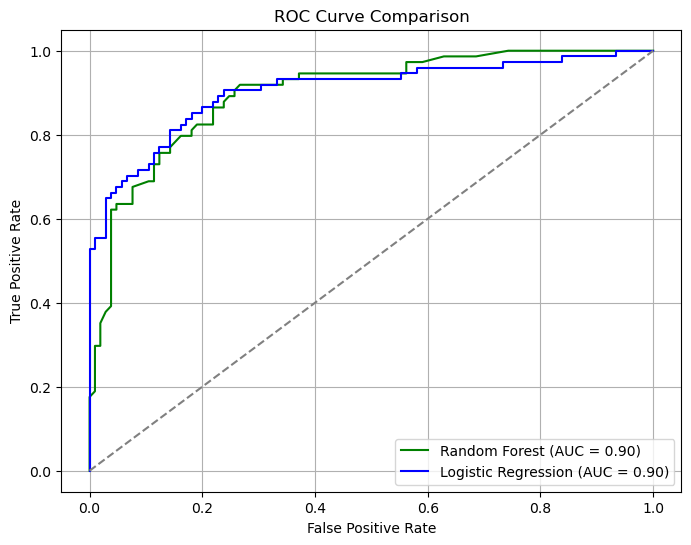

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [47]:
# Bias–Variance Analysis & Advanced Metrics


## 🎯 Goal of Bias–Variance Analysis

To **understand prediction errors** and choose the **right model complexity**.

When your model performs poorly, it’s usually due to:

* **High Bias** (underfitting)
* **High Variance** (overfitting)
  Your job is to balance the two.

---

## 🔍 Key Concepts

### 🔵 **Bias**

Bias is **error due to overly simplistic assumptions** in the learning algorithm.

* ❌ Model is too simple to capture the underlying data pattern
* ✅ Predicts consistently but inaccurately

**Example:** Linear Regression on highly non-linear data

---

### 🔴 **Variance**

Variance is **error due to sensitivity to small fluctuations** in the training data.

* ❌ Model fits training data too closely (overfitting)
* ✅ Predicts training data well but fails on new/unseen data

**Example:** Deep Decision Tree on small dataset

---

### ⚖️ The Trade-off

| Model Type  | Bias    | Variance | Result              |
| ----------- | ------- | -------- | ------------------- |
| Too Simple  | 🔼 High | 🔽 Low   | Underfitting        |
| Just Right  | ✅ Low   | ✅ Low    | Good generalization |
| Too Complex | 🔽 Low  | 🔼 High  | Overfitting         |

---

## 🧠 How to Spot Bias & Variance in Practice

### 1. **Train vs Test Accuracy**

| Scenario             | Train Acc | Test Acc | Likely Problem |
| -------------------- | --------- | -------- | -------------- |
| Both Low             | ❌ Low     | ❌ Low    | High Bias      |
| High Train, Low Test | ✅ High    | ❌ Low    | High Variance  |
| Both High            | ✅ High    | ✅ High   | Great!         |

---

## 🧪 Example (RandomForest vs LogisticRegression)

| Model               | Train Acc | Test Acc | Observation        |
| ------------------- | --------- | -------- | ------------------ |
| Logistic Regression | 82%       | 80%      | Balanced           |
| Random Forest       | 99%       | 83%      | Likely overfitting |

> So Random Forest has **low bias but higher variance** compared to Logistic.

---

## 🛠️ How to Fix Each

### 🔧 Reduce Bias (Underfitting)

* Use a more complex model (e.g. Random Forest, XGBoost)
* Add new features
* Reduce regularization (e.g. smaller `C` in LogisticRegression)

### 🔧 Reduce Variance (Overfitting)

* Use a simpler model
* Add more data
* Regularization (L1/L2)
* Prune trees, limit depth
* Cross-validation

---

## ✅ Takeaway

Bias–Variance tradeoff helps you:

* Understand **why your model is failing**
* Decide **what to tune** (model complexity, regularization, etc.)
* Choose between simpler vs. complex models for real-world deployment

---


In [49]:
print("Logistic Regression")
print("Train accuracy:", lr_best.score(X_train, y_train))
print("Test accuracy:", lr_best.score(X_test, y_test))

print("\nRandom Forest")
print("Train accuracy:", rf_best.score(X_train, y_train))
print("Test accuracy:", rf_best.score(X_test, y_test))


Logistic Regression
Train accuracy: 1.0
Test accuracy: 0.8324022346368715

Random Forest
Train accuracy: 1.0
Test accuracy: 0.8212290502793296
